In [1]:
# https://www.kaggle.com/code/nekokiku/simple-resnet-baseline
# https://zhuanlan.zhihu.com/p/1889819407540278719
# 微调resnet34模型
import os
import torchvision
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from tqdm import tqdm

# 临时指定画图字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 黑体
plt.rcParams['axes.unicode_minus'] = False  # 用于正常显示负号

# 1.查看label文件
BASE_DIR = '../data/kaggle-classify-leaves'
train_file_path = os.path.join(BASE_DIR, 'train.csv')
test_file_path = os.path.join(BASE_DIR, 'test.csv')
submission_file_path = os.path.join(BASE_DIR, 'sample_submission.csv')

train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)
submission_df = pd.read_csv(submission_file_path)
print(f"训练数据预览：\n{train_df.head(5)}")
print("-" * 100)
print(f"测试数据预览：\n{test_df.head(5)}")
print("-" * 100)
print(f"提交样例预览：\n{submission_df.head(5)}")
print("-" * 100)

训练数据预览：
          image             label
0  images/0.jpg  maclura_pomifera
1  images/1.jpg  maclura_pomifera
2  images/2.jpg  maclura_pomifera
3  images/3.jpg  maclura_pomifera
4  images/4.jpg  maclura_pomifera
----------------------------------------------------------------------------------------------------
测试数据预览：
              image
0  images/18353.jpg
1  images/18354.jpg
2  images/18355.jpg
3  images/18356.jpg
4  images/18357.jpg
----------------------------------------------------------------------------------------------------
提交样例预览：
              image                   label
0  images/18353.jpg      halesia_tetraptera
1  images/18354.jpg   robinia_pseudo-acacia
2  images/18355.jpg  chionanthus_virginicus
3  images/18356.jpg         ulmus_americana
4  images/18357.jpg           picea_pungens
----------------------------------------------------------------------------------------------------


In [6]:
# 查看数据集的基本信息
train_df.describe()

,image,label
count,18353,18353
unique,18353,176
top,images/18352.jpg,maclura_pomifera
freq,1,353


In [5]:
# 查看数据是否有缺失值
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18353 entries, 0 to 18352
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   18353 non-null  object
 1   label   18353 non-null  object
dtypes: object(2)
memory usage: 286.9+ KB


In [2]:
train_labels, unique_labels = pd.factorize(train_df['label'])
statistic_labels = train_df['label'].value_counts().index  # 按计数从大到小统计
print(f"训练标签预览：\n{train_labels[:10]}")
print("-" * 100)
print(f"唯一标签预览：\n{unique_labels}")
print("-" * 100)
print(f"统计标签预览：\n{statistic_labels}")

训练标签预览：
[0 0 0 0 0 0 1 2 0 2]
----------------------------------------------------------------------------------------------------
唯一标签预览：
Index(['maclura_pomifera', 'ulmus_rubra', 'broussonettia_papyrifera',
       'prunus_virginiana', 'acer_rubrum', 'cryptomeria_japonica',
       'staphylea_trifolia', 'asimina_triloba', 'diospyros_virginiana',
       'tilia_cordata',
       ...
       'prunus_serrulata', 'quercus_phellos', 'cedrus_deodara',
       'celtis_occidentalis', 'sassafras_albidum', 'acer_griseum',
       'ailanthus_altissima', 'pinus_thunbergii', 'crataegus_crus-galli',
       'juniperus_virginiana'],
      dtype='object', length=176)
----------------------------------------------------------------------------------------------------
统计标签预览：
Index(['maclura_pomifera', 'ulmus_rubra', 'prunus_virginiana', 'acer_rubrum',
       'broussonettia_papyrifera', 'prunus_sargentii', 'ptelea_trifoliata',
       'ulmus_pumila', 'abies_concolor', 'asimina_triloba',
       ...
       'amel

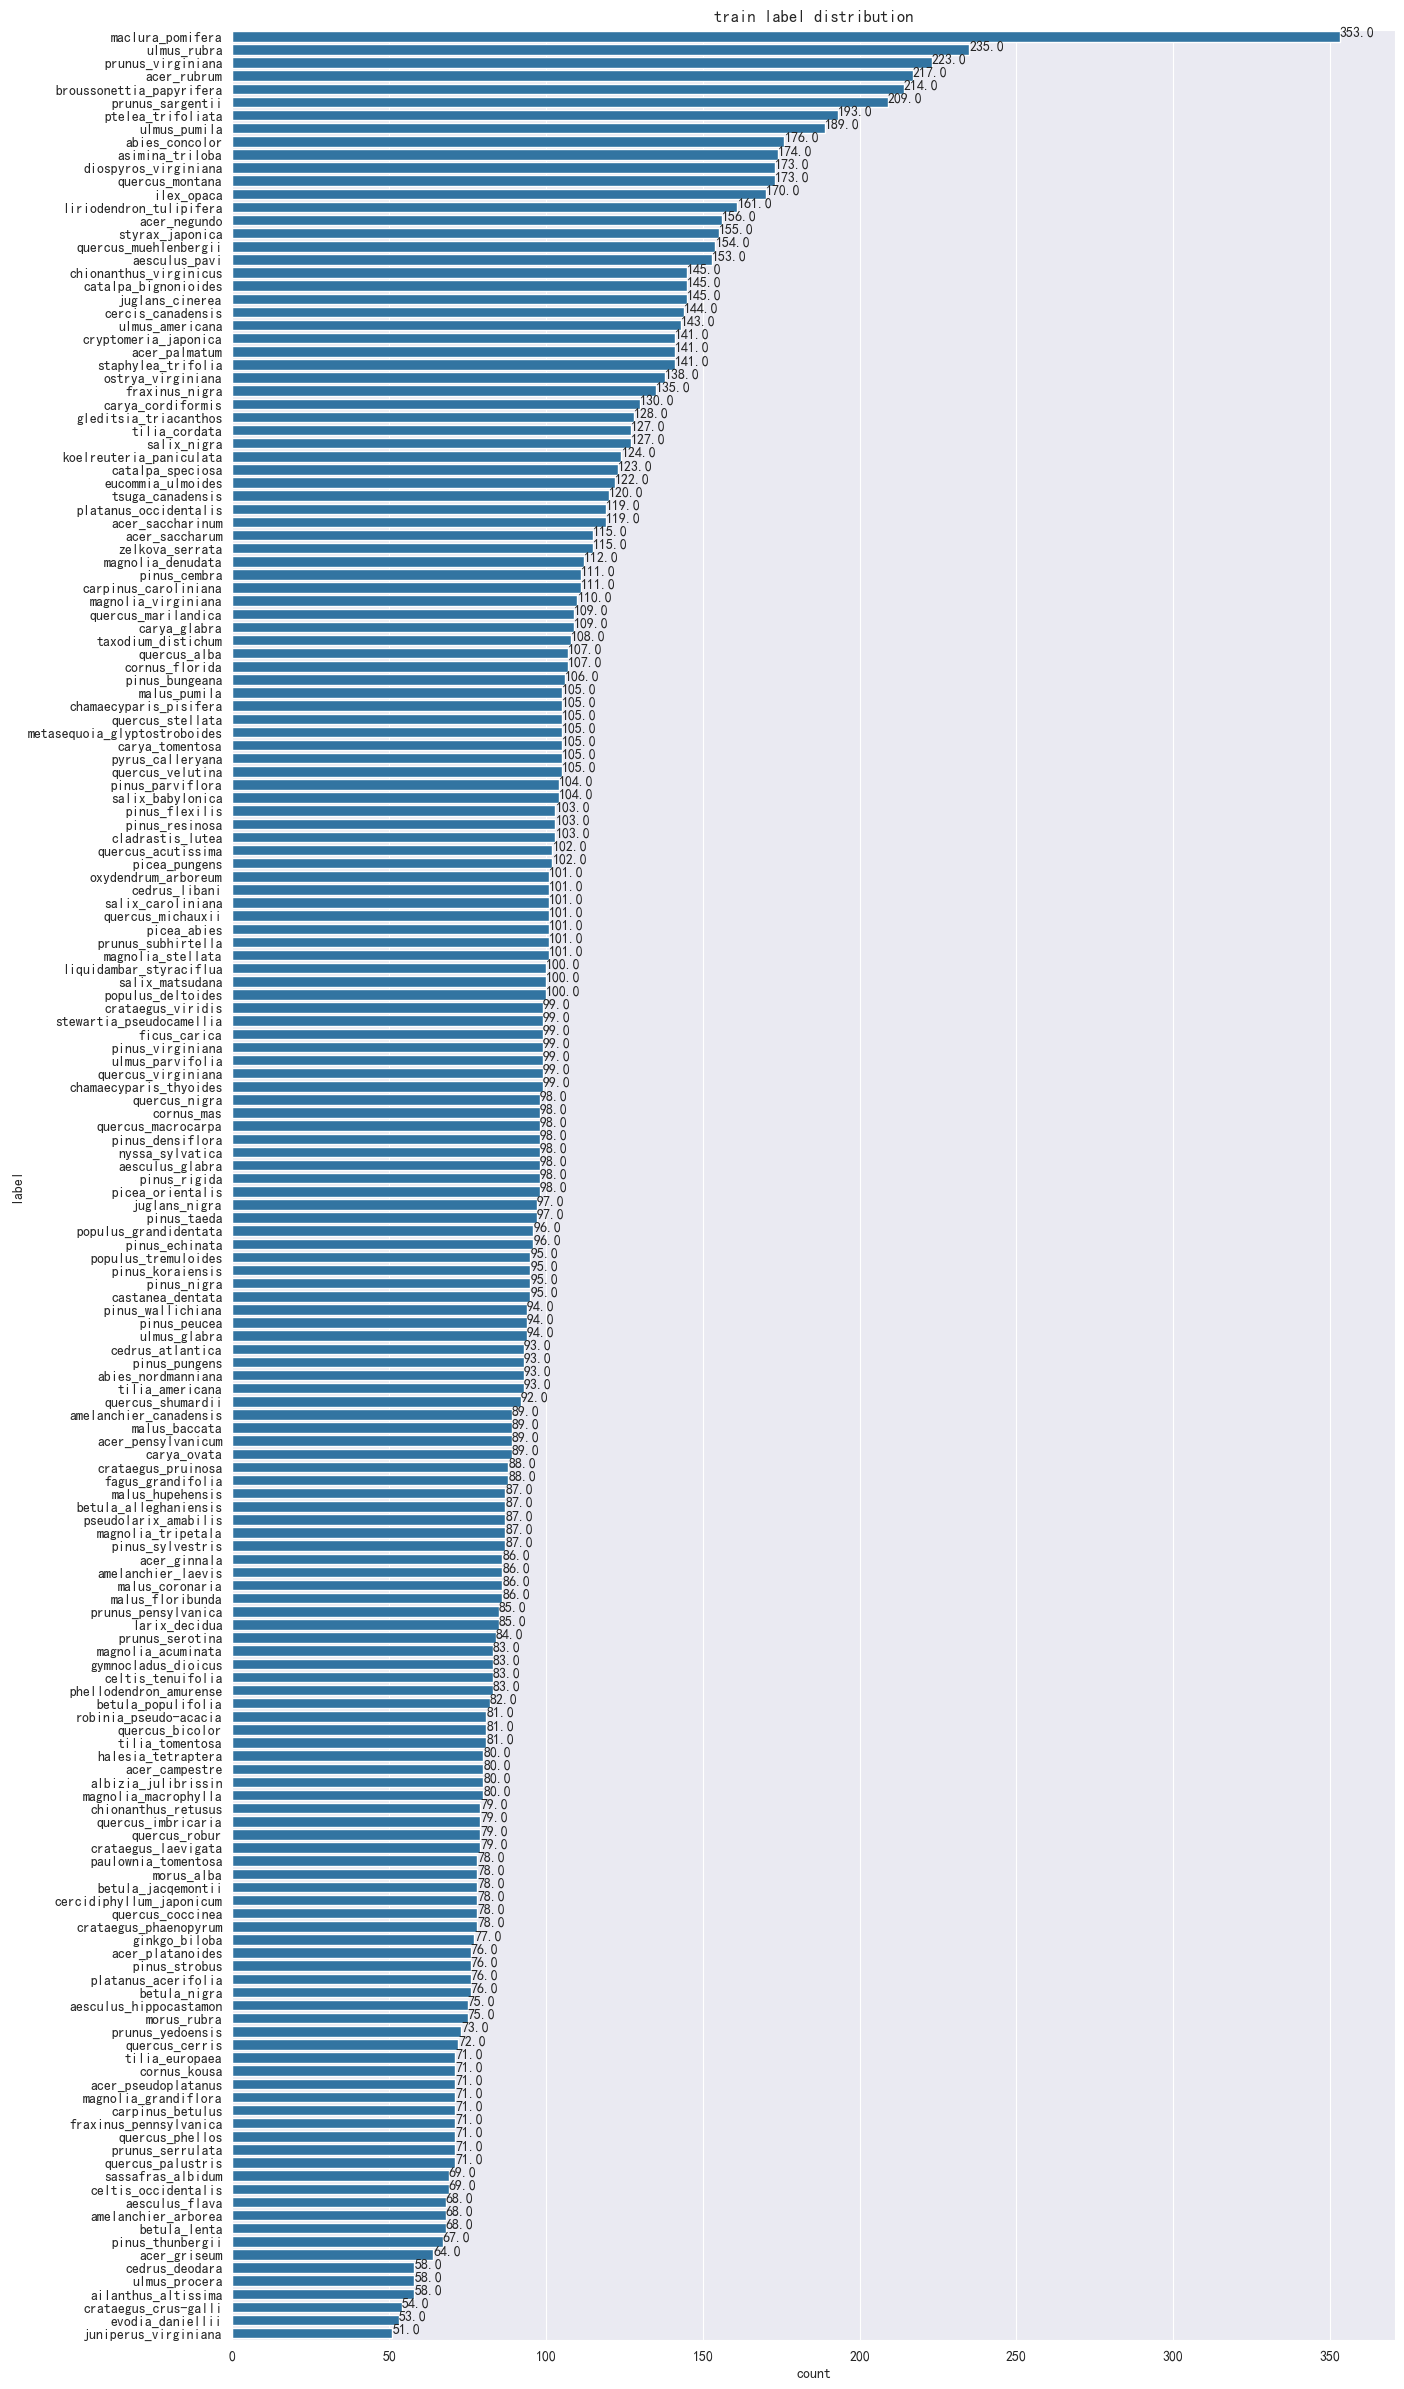

In [20]:
def barw(ax: plt.Axes):
    for p in ax.patches:
        val = p.get_width()  # height of the bar
        x = p.get_x() + p.get_width()  # x- position
        y = p.get_y() + p.get_height() / 2  # y-position
        ax.annotate(round(val, 2), (x, y))


plt.figure(figsize=(15, 30))
ax0 = sns.countplot(y=train_df['label'],
                    order=statistic_labels)
barw(ax0)
plt.title('train label distribution')
plt.show()

In [3]:
NUM_CLASSES = len(unique_labels)
print(f"类别数量：{NUM_CLASSES}")

class2index = dict(zip(unique_labels, train_labels))
index2class = dict(zip(train_labels, unique_labels))
print(f"标签到索引的映射：{class2index}")
print("-" * 100)
print(f"索引到标签的映射：{index2class}")

类别数量：176
标签到索引的映射：{'maclura_pomifera': np.int64(0), 'ulmus_rubra': np.int64(0), 'broussonettia_papyrifera': np.int64(0), 'prunus_virginiana': np.int64(0), 'acer_rubrum': np.int64(0), 'cryptomeria_japonica': np.int64(0), 'staphylea_trifolia': np.int64(1), 'asimina_triloba': np.int64(2), 'diospyros_virginiana': np.int64(0), 'tilia_cordata': np.int64(2), 'ulmus_pumila': np.int64(0), 'quercus_muehlenbergii': np.int64(3), 'juglans_cinerea': np.int64(0), 'cercis_canadensis': np.int64(3), 'ptelea_trifoliata': np.int64(2), 'acer_palmatum': np.int64(0), 'catalpa_speciosa': np.int64(0), 'abies_concolor': np.int64(2), 'eucommia_ulmoides': np.int64(0), 'quercus_montana': np.int64(1), 'koelreuteria_paniculata': np.int64(0), 'liriodendron_tulipifera': np.int64(0), 'styrax_japonica': np.int64(3), 'malus_pumila': np.int64(2), 'prunus_sargentii': np.int64(0), 'cornus_mas': np.int64(2), 'magnolia_virginiana': np.int64(1), 'ostrya_virginiana': np.int64(3), 'magnolia_acuminata': np.int64(0), 'ilex_opaca':

In [4]:
class LeavesData(Dataset):
    def __init__(self,
                 csv_path: str = r'../data/kaggle-classify-leaves/train.csv',
                 img_dir: str = r'../data/kaggle-classify-leaves/',
                 mode: str = 'train',
                 valid_ratio=0.2,
                 resize_height=256,
                 resize_width=256):
        """
        Args:
            :param csv_path: csv文件路径
            :param img_dir: 图片文件夹路径，csv文件中已经有images字段了，因此这里只到上一级目录
            :param mode: train/test
            :param valid_ratio: 验证集比例
            :param resize_height: 图片高度
            :param resize_width: 图片宽度
        """
        self.resize_height = resize_height
        self.resize_width = resize_width
        self.img_dir = img_dir
        self.mode = mode

        # 读取csv文件
        self.full_df = pd.read_csv(csv_path)
        self.data_len = len(self.full_df.index)
        self.train_len = int(self.data_len * (1 - valid_ratio))

        if mode == 'train':
            self.train_image = self.full_df.iloc[:self.train_len, 0].to_numpy()  # 'images/0.jpg'
            self.train_label = self.full_df.iloc[:self.train_len, 1].to_numpy()  # 'maclura_pomifera'
            self.image_arr = self.train_image.copy()
            self.label_arr = self.train_label.copy()
        elif mode == 'valid':
            self.valid_image = self.full_df.iloc[self.train_len:, 0].to_numpy()
            self.valid_label = self.full_df.iloc[self.train_len:, 1].to_numpy()
            self.image_arr = self.valid_image.copy()
            self.label_arr = self.valid_label.copy()
        elif mode == 'test':
            self.test_image = self.full_df.iloc[:, 0].to_numpy()
            self.image_arr = self.test_image.copy()
        print(f"{mode}数据集完成读取，长度：{len(self.image_arr)}")

    def __len__(self):
        return len(self.image_arr)

    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.img_dir, self.image_arr[idx]))
        if self.mode == 'train':
            transform = transforms.Compose([
                transforms.Resize((self.resize_height, self.resize_width)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.ToTensor(),
            ])
        else:  # valid和test不做数据增强
            transform = transforms.Compose([
                transforms.Resize((self.resize_height, self.resize_width)),
                transforms.ToTensor(),
            ])

        if self.mode == 'test':
            return transform(image)
        else:
            label = self.label_arr[idx]
            return transform(image), class2index[label]


train_set = LeavesData(mode='train')
test_set = LeavesData(mode='test')
valid_set = LeavesData(mode='valid')
# 检查前10个样本
for i in range(10):
    X, y = train_set[i]
    print(f"样本{i}的特征维度{X.shape}, 对应的标签为{y}")

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=64, shuffle=False)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

train数据集完成读取，长度：14682
test数据集完成读取，长度：18353
valid数据集完成读取，长度：3671
样本0的特征维度torch.Size([3, 256, 256]), 对应的标签为0
样本1的特征维度torch.Size([3, 256, 256]), 对应的标签为0
样本2的特征维度torch.Size([3, 256, 256]), 对应的标签为0
样本3的特征维度torch.Size([3, 256, 256]), 对应的标签为0
样本4的特征维度torch.Size([3, 256, 256]), 对应的标签为0
样本5的特征维度torch.Size([3, 256, 256]), 对应的标签为0
样本6的特征维度torch.Size([3, 256, 256]), 对应的标签为0
样本7的特征维度torch.Size([3, 256, 256]), 对应的标签为0
样本8的特征维度torch.Size([3, 256, 256]), 对应的标签为0
样本9的特征维度torch.Size([3, 256, 256]), 对应的标签为0


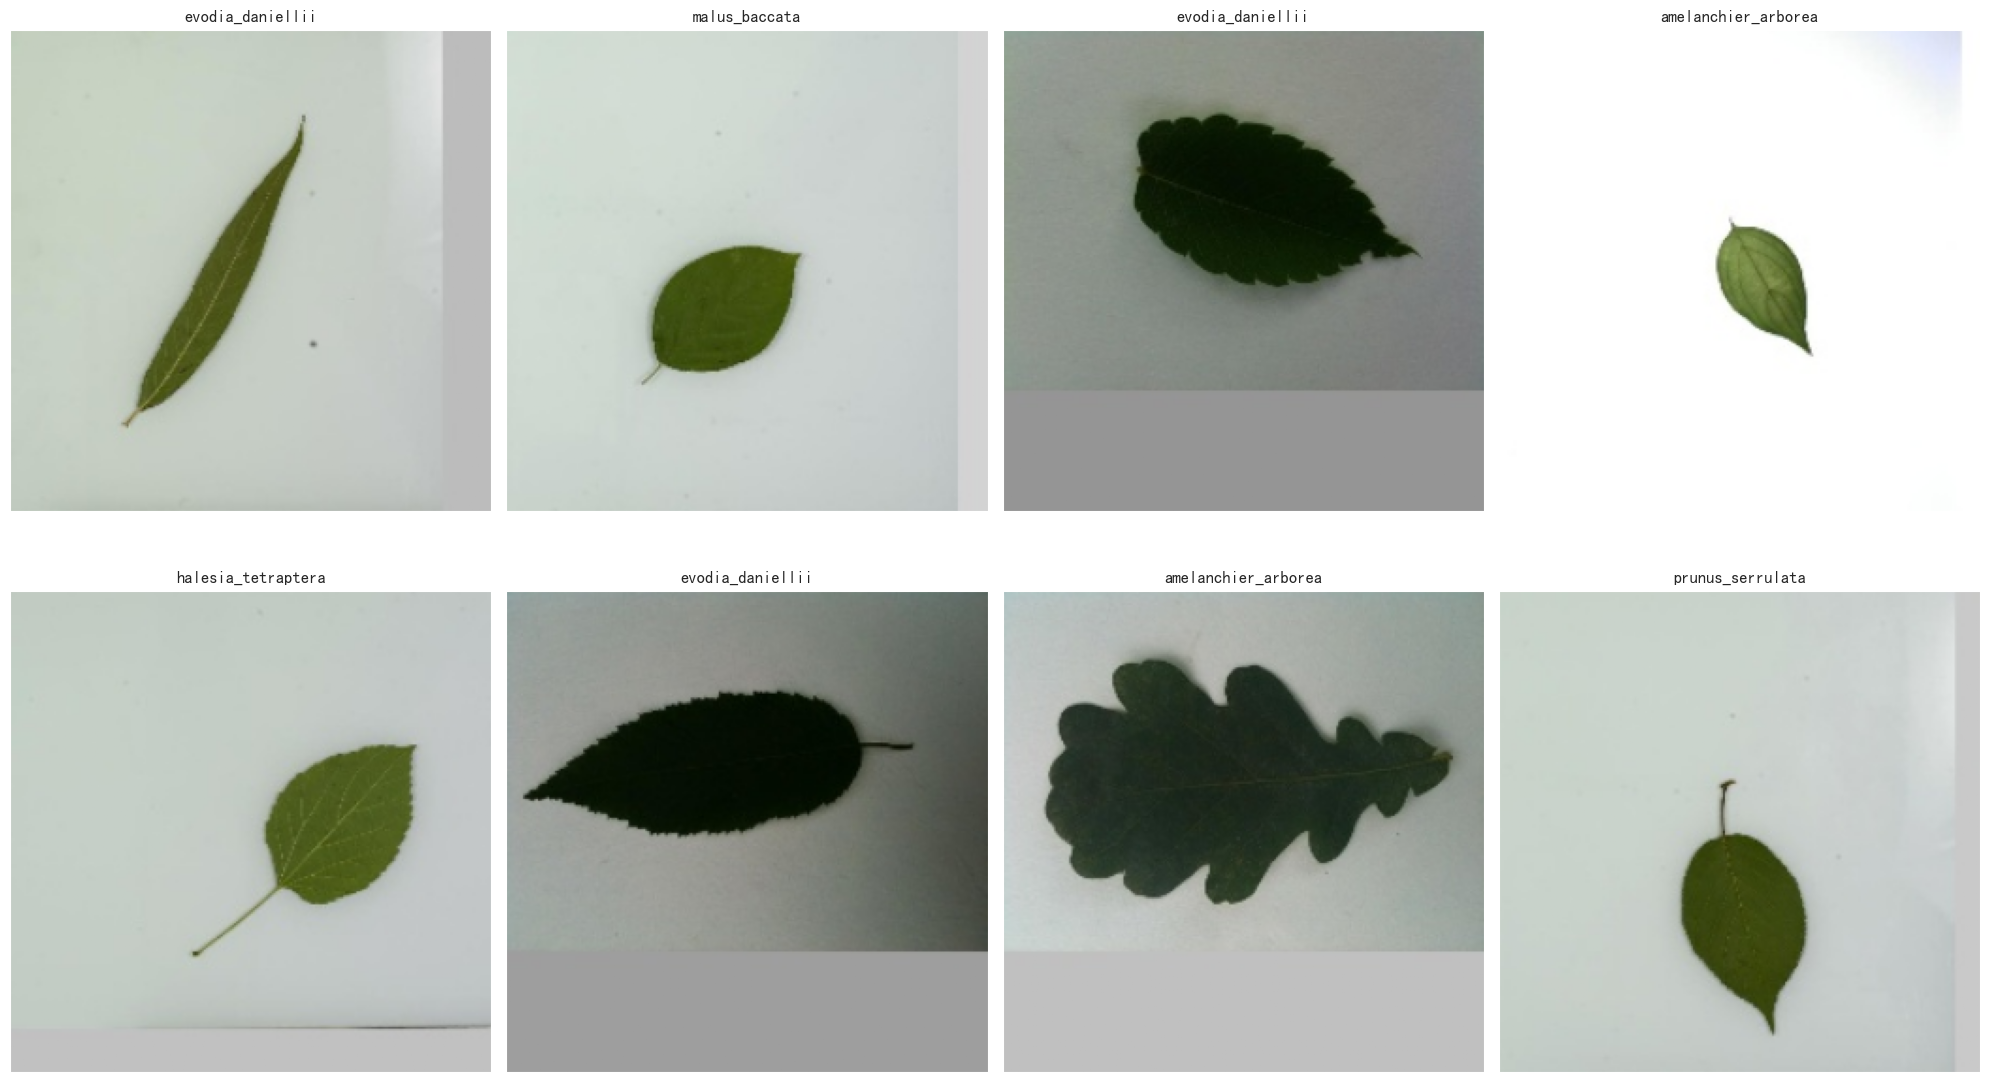

In [55]:
# 查看图片
def display_dataset_images(data_loader, num_to_class, rows=2, columns=4, figsize=(20, 12), device="cpu"):
    """
    更高效地显示数据集中的图像

    参数:
        data_loader: PyTorch DataLoader对象，包含要显示的图像数据
        num_to_class: 字典，将数字标签映射到类名
        rows: 图像网格的行数，默认为2
        columns: 图像网格的列数，默认为4
        figsize: 图表大小，默认为(20, 12)
        device: 运行设备，默认为"cpu"
    """
    # 创建图表
    fig = plt.figure(figsize=figsize)

    # 获取一批数据
    try:
        dataiter = iter(data_loader)
        inputs, classes = next(dataiter)
    except StopIteration:
        print("数据加载器为空，无法显示图像")
        return

    # 确定要显示的图像数量（不超过批次大小）
    num_images = min(rows * columns, len(inputs))

    # 一次性转换所有图像以提高效率
    with torch.no_grad():  # 关闭梯度计算以提高性能
        for idx in range(num_images):
            # 创建子图
            ax = fig.add_subplot(rows, columns, idx + 1, xticks=[], yticks=[])

            # 获取并转换单个图像
            img = inputs[idx].to(device)
            img = img.cpu().numpy().transpose(1, 2, 0)

            # 处理不同类型的图像数据
            if img.shape[2] == 1:  # 灰度图像
                img = img.squeeze(2)
                cmap = 'gray'
            else:  # 彩色图像
                cmap = None

            # 处理值范围
            if img.max() > 1.0 or img.min() < 0.0:
                # 如果值超出[0,1]范围，归一化到[0,1]
                img = (img - img.min()) / (img.max() - img.min() + 1e-8)
            else:
                # 否则只需裁剪到[0,1]
                img = np.clip(img, 0, 1)

            # 设置标题并显示图像
            title = num_to_class[int(classes[idx])] if idx < len(classes) else "未知"
            ax.set_title(title)
            ax.imshow(img, cmap=cmap)

    # 调整子图布局以防止重叠
    plt.tight_layout()
    plt.show()


def display_grid_from_batch(batch_tensor, rows=8, cols=8, figsize=(10, 10), normalize=True):
    """
    使用torchvision.utils创建图像网格显示

    参数:
        batch_tensor: 形状为[B, C, H, W]的图像批次张量
        rows: 网格行数
        cols: 网格列数
        figsize: 图表大小
        normalize: 是否归一化图像值到[0,1]
    """
    # 确保不尝试显示超过批次中实际图像数量
    num_images = min(rows * cols, batch_tensor.size(0))

    # 选择要显示的图像
    images = batch_tensor[:num_images]

    # 使用torchvision.utils创建网格
    grid = torchvision.utils.make_grid(images, nrow=cols, normalize=normalize, padding=2)

    # 转换为numpy以显示
    grid_np = grid.cpu().numpy().transpose(1, 2, 0)

    # 显示网格
    plt.figure(figsize=figsize)
    plt.imshow(grid_np)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# 示例用法:
display_dataset_images(valid_loader, index2class, rows=2, columns=4)
#
# # 或者使用网格显示一批图像:
# dataiter = iter(val_loader)
# images, _ = next(dataiter)
# display_grid_from_batch(images, rows=4, cols=4)

In [5]:
pmodel = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
print(pmodel)
# Freeze all layers
for param in pmodel.parameters():
    param.requires_grad = False

# 查看层的名称和是否需要梯度
for name, param in pmodel.named_parameters():
    print(f"Layer Name: {name}, \nParameters Shape: {param.shape}")
    print('--'*50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
pmodel.layer1

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, mome

In [11]:
pmodel.layer1[0]

BasicBlock(
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [16]:
print(pmodel.layer1[0].conv1)
print('--'*50)
print(pmodel.layer1[0].conv1.weight)

Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
----------------------------------------------------------------------------------------------------
Parameter containing:
tensor([[[[-5.2873e-03,  1.4928e-02, -5.9448e-03],
          [-6.0405e-02, -2.4320e-02, -2.6518e-02],
          [-8.3909e-04, -1.5741e-02,  8.9452e-03]],

         [[-1.9168e-02, -9.6824e-03, -3.0960e-02],
          [-1.6810e-03,  1.8769e-02, -1.1106e-02],
          [ 1.4279e-02, -6.6381e-03, -2.0193e-02]],

         [[-2.5077e-02,  1.4267e-03, -2.3917e-02],
          [ 2.0311e-02, -2.4613e-03, -1.5927e-02],
          [ 1.0350e-02,  1.5806e-02,  4.6806e-04]],

         ...,

         [[-4.0992e-03, -2.1593e-03,  7.2147e-03],
          [-2.4061e-02,  5.7196e-02, -1.6450e-02],
          [ 4.1199e-02, -1.5606e-02, -2.0907e-02]],

         [[-2.1526e-03,  3.6051e-03, -2.3032e-02],
          [ 1.9661e-02,  1.5548e-02,  2.3233e-02],
          [-4.2434e-02, -3.9219e-02, -2.4433e-02]],

         

In [13]:
for name, param in pmodel.layer1[0].named_parameters():
    print(f"Layer Name: {name}, \nParameters Shape: {param.shape}")
    print('--'*50)

Layer Name: conv1.weight, 
Parameters Shape: torch.Size([64, 64, 3, 3])
----------------------------------------------------------------------------------------------------
Layer Name: bn1.weight, 
Parameters Shape: torch.Size([64])
----------------------------------------------------------------------------------------------------
Layer Name: bn1.bias, 
Parameters Shape: torch.Size([64])
----------------------------------------------------------------------------------------------------
Layer Name: conv2.weight, 
Parameters Shape: torch.Size([64, 64, 3, 3])
----------------------------------------------------------------------------------------------------
Layer Name: bn2.weight, 
Parameters Shape: torch.Size([64])
----------------------------------------------------------------------------------------------------
Layer Name: bn2.bias, 
Parameters Shape: torch.Size([64])
----------------------------------------------------------------------------------------------------


In [18]:
state_dict = pmodel.state_dict()
print(state_dict.keys())

odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.weight', 'layer1.1.bn2.weight', 'layer1.1.bn2.bias', 'layer1.1.bn2.running_mean', 'layer1.1.bn2.running_var', 'layer1.1.bn2.num_batches_tracked', 'layer1.2.conv1.weight', 'layer1.2.bn1.weight', 'layer1.2.bn1.bias', 'layer1.2.bn1.running_mean', 'layer1.2.bn1.running_var', 'layer1.2.bn1.num_batches_tracked', 'layer1.2.conv2.weight', 'layer1.2.bn2.weight', 'layer1.2.bn2.bias', '